In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from __future__ import division
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


#Project 1 - Large Building Energy and Water Consumption in NYC

*Author:* Theodore Love

*Date:* February 23, 2015

**Contents**
1. Overview of Data Collection
2. Importing and Cleaning Data
3. Deriving Features and Subgroups
4. Effects of Normalizing Variables
5. EUI by Property Type
6. ENERGY STAR Score
7. Water Usage
8. Next Steps

## 1. Overview of Data Collection

This analysis is primarily based on data relating to [NYC Local Law 84](http://www.nyc.gov/html/gbee/html/plan/ll84.shtml), which requires private sector buildings that are larger than 50,000 square feet, and two or more private sector buildings on a single lot that are larger than 100,000 square feet, to provide annual data on energy and water consumption. Significant analysis has been done on this data set and presented in a [series of reports](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml). This analysis attempts to extend this previous work.

The original data covers five basic categories of information:
* Building Location (borough/block/lot, address, etc.)
* Building Info (building type, square footage, id, etc.)
* Energy Usage (gross kBTUs/ft2, weather normalized kBTUs/ft2, ENERGY STAR score)
* Water Usage per ft2 (along with source)
* GHG Emissions (calculated from kBtu/ft2 and a coefficient estimate)

All of this data is sourced from [NYC Open Data](https://nycopendata.socrata.com/). 

**Current data sets used**

|Name | Source |
|---| --- |
|Local Law 84 Disclosures (2011) | [Source](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/q39e-7gbs)|
|Local Law 84 Disclosures (2012 | [Source](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/5gde-fmj3)|

The data has both zip code and borough/block/lot information, which makes for a good way to work in other data sets. I have identified the following data sets that also are by building/block/lot that may be interesting additions to the data in the future.

## 2. Importing and Cleaning Data

Data was available for 2011 and 2012, and the main reporting requirement was energy use intensity in kBTUs/ft2 (EUI), with water usage and ENERGY STAR score as an optional value, and the other main fields assigned or calculated. In general:
* 2011 had about 1/5th as many buildings with some reported data as 2012 (~2,500 vs ~11,000)
* Water usage was reported in about 10% of cases for 2011, and 50% for 2012
* About 1,600 buildings reported ENERGY STAR scores in each year
* 2012 had an extra column detailing the source of the water data (whether it was automatically assigned or generated by NYC).

####Dropping Extraneous Observations and Consolidating Data

The main goal of this analysis was to evaluate energy usage, so initial cleanup focused on buildings with this information

In [13]:
# set the data folder filepath
data_folder = '/Users/Theo/Dropbox (Personal)/ProgrammingProjects/GADSdata'

# import the raw data sets
ll84_2011 = pd.read_csv(data_folder + '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2011.csv')
ll84_2012 = pd.read_csv(data_folder +  '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2012.csv')

# remove rows that don't have weather normalized EUI
ll84_2011 = ll84_2011[pd.notnull(ll84_2011['Weather Normalized Source EUI'])]
ll84_2012 = ll84_2012[pd.notnull(ll84_2012['Weather Normalized Source EUI(kBtu/ft2)'])]

# make the column names more maneagable
ll84_2011.columns = "bbl st_no st_name borough zip bench_sub entry_no EUI EUIwn water_ft2 \
            energy_star GHG floor_area property_type no_buildings reported_BINS".split()
ll84_2012.columns = "bbl st_no st_name borough zip bench_sub entry_no EUI EUIwn water_ft2 \
            water_method energy_star GHG floor_area property_type no_buildings reported_BINS".split()


# add the 'water_method' column to 1184_2011 with 'Manual' if a value is entered
def make_manual(x):
    if pd.notnull(x):
        return 'Manual'
    else:
        return np.NaN
    
ll84_2011['water_method'] = ll84_2011['water_ft2'].apply(lambda x: make_manual(x))

# add the year columns and dummy variables for 2011 and 2012
ll84_2011['year'] = [2011] * len(ll84_2011)
ll84_2011['yr_2011'] = [1] * len(ll84_2011)
ll84_2011['yr_2012'] = [0] * len(ll84_2011)

ll84_2012['year'] = [2012] * len(ll84_2012)
ll84_2012['yr_2011'] = [0] * len(ll84_2012)
ll84_2012['yr_2012'] = [1] * len(ll84_2012)

# sort columns and combine data sets
buildings = pd.concat([ll84_2011.sort(axis=1), ll84_2012.sort(axis=1)])

# seven buildings have energy_star as 'Exempt', while the rest are numbers.
# change these instances to NaN, and convert the ints stored as strings
def fix_estar(x):
    if x == 'Exempt':
        return np.NaN
    else:
        return float(x)

buildings['energy_star'] = buildings['energy_star'].apply(lambda x: fix_estar(x))

buildings.describe()

,EUI,EUIwn,GHG,bbl,energy_star,entry_no,floor_area,no_buildings,water_ft2,year,yr_2011,yr_2012,zip
count,13390.000000,13390.000000,13329.000000,1.339000e+04,3381.000000,13390.000000,13390.000000,13390.000000,6811.000000,13390.000000,13390.000000,13390.000000,13390.000000
mean,473.954899,666.847901,11582.862957,2.138298e+09,62.153801,5514.694847,208070.507319,1.874160,62.221126,2011.826811,0.173189,0.826811,10537.026512
std,6828.826821,8441.201591,261880.184929,1.244401e+09,28.735408,3930.652746,507788.669316,6.042515,603.393207,0.378425,0.378425,0.378425,620.713896
min,0.000000,0.000000,0.010000,1.000048e+09,1.000000,1.000000,0.000000,0.000000,0.000000,2011.000000,0.000000,0.000000,0.000000
25%,58.800000,102.300000,337.200000,1.012170e+09,44.000000,1883.250000,67004.500000,1.000000,0.655000,2012.000000,0.000000,1.000000,10022.000000
50%,77.500000,134.800000,552.300000,2.025840e+09,69.000000,4992.500000,98753.000000,1.000000,29.850000,2012.000000,0.000000,1.000000,10452.000000
75%,100.400000,188.700000,1144.830000,3.059820e+09,85.000000,8957.750000,176247.250000,1.000000,56.375000,2012.000000,0.000000,1.000000,11218.000000
max,494449.300000,576072.000000,22449210.270000,5.079910e+09,100.000000,13040.000000,14217119.000000,160.000000,41737.050000,2012.000000,1.000000,1.000000,11694.000000


####Removing Anomalies

The data for Local Law 84 is self reported, so we expect there to be some issues. This next section of code cleans up some anomalies found in the analysis of the data. Further analysis could go in to why these observations were anomalous, but a full exploration of anomalies is beyond the scope of this analysis. While much of this analysis is looking for why buildings have higher or lower usage, the effect of anomalies in this data is very apparent in an analysis of summary stats, that removing will greatly help to look at underelying trends.

In [14]:
curr = len(buildings)
print "Anomalies"
print "========="
print "Starting observations: %i" % curr

# Remove observations with an EUI of 0
buildings = buildings[buildings['EUI'] > 0]
print "EUI of 0: %i" % (curr - len(buildings))
curr = len(buildings)

# EUI is a levelized value (i.e. per ft2), so really small or large numbers are suspicious
# Really small numbers are less problematic as they are bounded by 0 and could mean an empty building
# But large numbers probably indicate that there is an issue in the data (either the usage or size)
# Analysis done by other firms uses a min EUI of 5 and a max of 1000
buildings = buildings[buildings['EUIwn'] >= 5]
print "EUIwn < 5: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[buildings['EUIwn'] <= 1000]
print "EUI > 1,000: %i" % (curr - len(buildings))
curr = len(buildings)

# LL84 is supposed to be for buildings that are bigger than 50k ft2
# Giving the building owner a reasonable margin (50%) for "floor area",
# we are removing any observations that have floor_area < 25,000
buildings = buildings[buildings['floor_area'] >= 25000]
print "floor area < 25k ft2: %i" % (curr - len(buildings))
curr = len(buildings)

# A few properties do not have GHG readings, so remove them
buildings = buildings[pd.notnull(buildings['GHG'])]
print "Missing GHG: %i" % (curr - len(buildings))
curr = len(buildings)

# water per foot2 also has some abnormally high values that don't make sense
# change anything with > 100 gallons per ft2 to NaN, but do not remove full observation
def filter_water(x):
    if x > 100:
        return np.NaN
    else:
        return x
print "Water per ft2 > 100: %i (kept observation)" % len(buildings[buildings['water_ft2'] > 100])  
buildings['water_ft2'] = buildings['water_ft2'].apply(lambda x: filter_water(x))

print "Remaining observations: %i" % len(buildings)
print
buildings.describe()

Anomalies
Starting observations: 13390
EUI of 0: 96
EUIwn < 5: 62
EUI > 1,000: 153
floor area < 25k ft2: 320
Missing GHG: 44
Water per ft2 > 100: 499 (kept observation)
Remaining observations: 12715



,EUI,EUIwn,GHG,bbl,energy_star,entry_no,floor_area,no_buildings,water_ft2,year,yr_2011,yr_2012,zip
count,12715.000000,12715.000000,12715.000000,1.271500e+04,3281.00000,12715.000000,12715.000000,12715.000000,6057.000000,12715.000000,12715.000000,12715.000000,12715.000000
mean,85.044569,159.924986,1619.800245,2.122087e+09,63.17708,5538.059143,213682.804247,1.634919,30.016999,2011.828313,0.171687,0.828313,10533.337475
std,56.082675,106.916751,5632.590501,1.237917e+09,27.73860,3929.643221,511170.496929,5.383801,27.706826,0.377123,0.377123,0.377123,616.113987
min,1.500000,5.000000,8.820000,1.000048e+09,1.00000,1.000000,25000.000000,0.000000,0.000000,2011.000000,0.000000,0.000000,0.000000
25%,59.200000,102.500000,355.800000,1.012090e+09,45.00000,1916.000000,69397.000000,1.000000,0.070000,2012.000000,0.000000,1.000000,10021.000000
50%,77.000000,133.600000,567.990000,2.024860e+09,70.00000,5092.000000,101649.000000,1.000000,26.810000,2012.000000,0.000000,1.000000,10451.000000
75%,98.500000,186.050000,1149.065000,3.057820e+09,85.00000,9011.500000,179822.000000,1.000000,48.960000,2012.000000,0.000000,1.000000,11217.000000
max,808.500000,996.400000,88132.580000,5.079910e+09,100.00000,13040.000000,14217119.000000,160.000000,99.970000,2012.000000,1.000000,1.000000,11694.000000


## 3. Deriving Features and Subgroups

####Deriving New Features

In order to facilitate various graphing and other analysis, a number of new columns, derived from existing ones were created.

In [15]:
# normalize continuous features
buildings['EUI_norm'] = buildings.EUI / buildings.EUI.max()
buildings['EUIwn_norm'] = buildings.EUIwn / buildings.EUIwn.max()
buildings['GHG_norm'] = buildings.GHG / buildings.GHG.max()
buildings['floor_area_norm'] = buildings.floor_area / buildings.floor_area.max()
buildings['water_ft2_norm'] = buildings.water_ft2 / buildings.water_ft2.max()

# break out bbl in to borough_no, block_no, and lot_no
buildings['borough_no'] = buildings.bbl.apply(lambda x: int(str(x)[0:1]))
buildings['block_no'] = buildings.bbl.apply(lambda x: int(str(x)[1:6]))
buildings['lot_no'] = buildings.bbl.apply(lambda x: int(str(x)[6:10]))

# create a numerical column for property_type
temp_list = list(buildings.property_type.unique())
p_types = dict(zip(temp_list, range(1, len(temp_list)+1)))
buildings['p_type'] = buildings['property_type'].apply(lambda x: p_types[x])

# dummy for  automatically created water_method (ABS)
def is_abs(x):
    if x == "ABS":
        return 1
    else:
        return 0
buildings['method_ABS'] = buildings['water_method'].apply(lambda x: is_abs(x))

# dummy variables for borough
buildings = pd.concat([buildings, pd.get_dummies(buildings.borough)], axis=1)

# dummy variables for property type
buildings = pd.concat([buildings, pd.get_dummies(buildings.property_type)], axis=1)

####Identifying Major Property Groupings
A common grouping for comparing building data is the **property_type**. As shown by the table below, most of the observations in the data set are for "Multifamily Housing", then "Office", and then a steep drop off.

In [16]:
property_types = buildings[["EUI","property_type"]].groupby(buildings['property_type']).count().sort('EUI', ascending=0)
print property_types['EUI']

property_type
Multifamily Housing                                             8166
Office                                                          2137
Other                                                            398
Warehouse (Unrefrigerated)                                       386
Hotel                                                            279
Retail                                                           198
Senior Care Facility                                             177
Residence Hall/Dormitory                                         154
Hospital (General Medical and Surgical)                          135
K-12 School                                                      133
College/University (Campus-Level)                                125
Self-Storage                                                      71
Medical Office                                                    55
Entertainment/Culture                                             38
Bank/Financial Insti

This table suggests three different subgroups:
 * Multifamily Housing
 * Offices 
 * Property types with count > 100 (i.e. decent sample size), and, if we exclude "other" we have the top ten types
 
If our goal is to have some sort of actionable energy benchmarking and/or predictive power, and the data represents such a diverse building stock, isolating the **property_types** where we think we can have the most impact and focusing on analysis specific to those groups makes the most sense. The two most represented property types are, by far, **Multifamily** and **Office**, making up a combined 83% of the 2012 data's total square footage.

The main bulk of analysis going forward will probably focus on **Multifamily** housing (one of the most hot-button issues in current local politics), with some additional looks at the **Office** subgroup as well. Since we are focusing on a more defined subset, it is worth removing extreme outliers for this subset. These outliers may be worth separate analysis at a later time.

In [17]:
# create the multifamily subgroup
# remove top and bottom 1% of EUI weather normalized as outliers
multifamily = buildings[buildings.property_type == 'Multifamily Housing']
mf_top1 = multifamily['EUIwn'].quantile(0.99)
mf_bot1 = multifamily['EUIwn'].quantile(0.01)
multifamily = multifamily[(multifamily['EUIwn'] < mf_top1) & (multifamily['EUIwn'] > mf_bot1)]

# create the offices subgroup
# remove top and bottom 1% of EUI weather normalized as outliers
office = buildings[buildings.property_type == 'Office']
of_top1 = office['EUIwn'].quantile(0.99)
of_bot1 = office['EUIwn'].quantile(0.01)
office = office[(office['EUIwn'] < of_top1) & (office['EUIwn'] > of_bot1)]

# Create the group with 100+ observations
top10_types = list(property_types[property_types['EUI'] > 100].index)
top10_types.remove('Other')
top10 = buildings[buildings['property_type'].isin(top10_types)]

####Split by Year

Since the data contains more than one year of information, we should split all of our groups by year, and make a list for each subgroup that contains the full data set and each sub-year. Also, in order to do better analysis on these individual sets, we must normalize the continuous variables against the maximum for just that subgroup.

In [18]:
# split up the data in to 2011 and 2012
def split_years(df):
    return (df[df.year == 2011], df[df.year == 2012])

buildings_2011, buildings_2012 = split_years(buildings)
top10_2011, top10_2012 = split_years(top10)
multifamily_2011, multifamily_2012 = split_years(multifamily)
office_2011, office_2012 = split_years(office)

# create a list for each sub-group
buildings_sets = [buildings, buildings_2011, buildings_2012]
top10_sets = [top10, top10_2011, top10_2012]
multifamily_sets = [multifamily, multifamily_2011, multifamily_2012]
office_sets = [office, office_2011, office_2012]

# create a master list
all_sets = [buildings_sets, top10_sets, multifamily_sets, office_sets]

# Create the main variables normalized against the max for that subgroup, and not the entire dataset
def normalize_local(df):
    df['EUI_localnorm'] = df.EUI / df.EUI.max()
    df['EUIwn_localnorm'] = df.EUIwn / df.EUIwn.max()
    df['GHG_localnorm'] = df.GHG / df.GHG.max()
    df['floor_area_localnorm'] = df.floor_area / df.floor_area.max()
    df['water_ft2_localnorm'] = df.water_ft2 / df.water_ft2.max()

for dataset in all_sets:
    for df in dataset:
        normalize_local(df)

####Current State of Data
We now have a cleaned up data, with the following new columns:
* Normalized continuous variables (i.e. % of full data set max) for:
    * EUI
    * Weather normalized EUI
    * GHG
    * Water Usage
    * Floor area
* Separate numerical columns for borough, block, and lot
* Dummy variables for each borough
* The property_type column represented by numerical categories
* Dummy variables for each property_type

We also have the following sub-groups, each with its own combined, 2011, and 2012 subgroup, and continuous variables normalized against the sub-group maximum:
1. buildings - all the data
2. top10 - the top ten property types
3. multifamily - the multifamily buildings
4. office - the office buildings

# 4. EUI by Property Type

In general we see that **Hospitals** have a much larger energy signature than most of the other groups, while **Multifamily** and **Warehouses** are on the lower end.

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


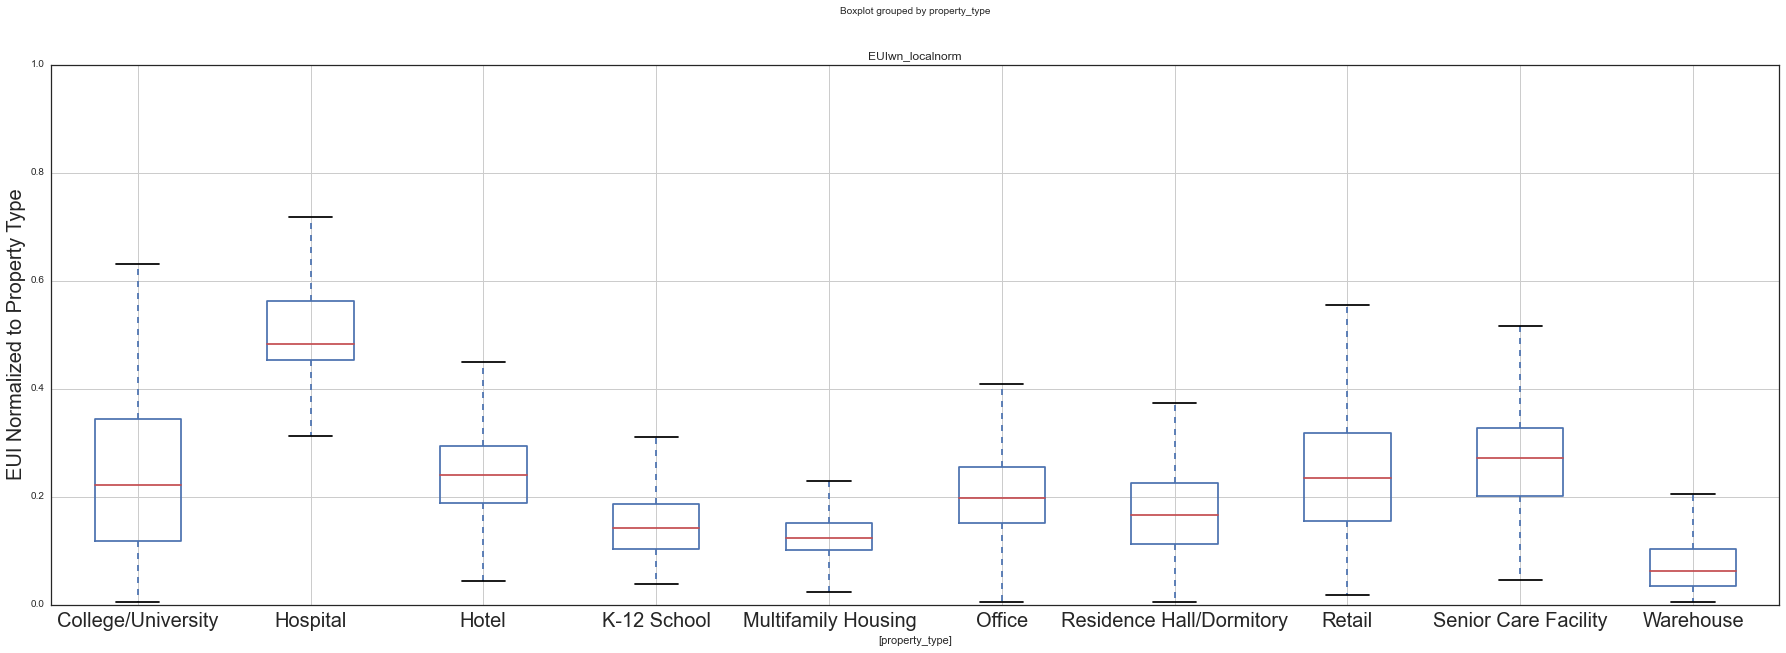

In [27]:
def shorten_type(x):
    if x == 'Hospital (General Medical and Surgical)':
        return 'Hospital'
    elif x == 'Warehouse (Unrefrigerated)':
        return 'Warehouse'
    elif x == 'College/University (Campus-Level)':
        return 'College/University'
    else:
        return x

top10['property_type'] = top10['property_type'].apply(lambda x: shorten_type(x))
    
plt.figure(figsize=(10,10))

a1 = top10[['property_type', 'EUIwn_localnorm']].boxplot(by='property_type', figsize=(30,10), fontsize=20)
plt.ylabel('EUI Normalized to Property Type', fontsize=20)
plt.show()

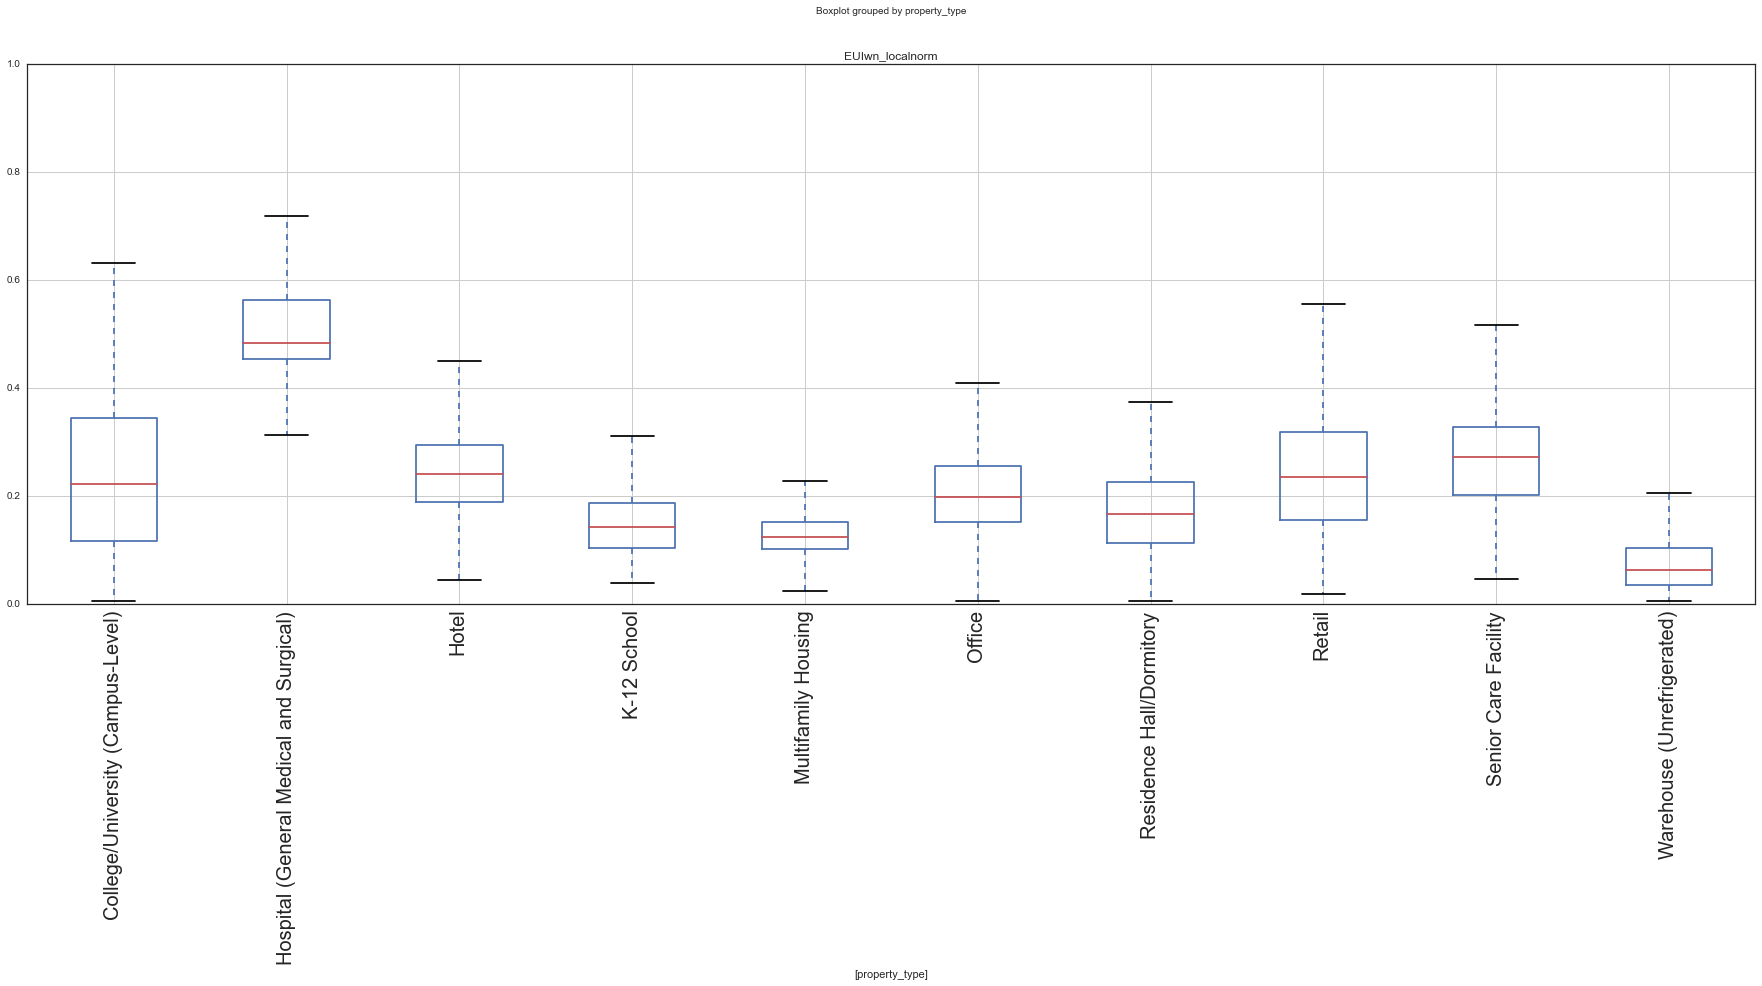

In [20]:
plt.figure(figsize=(10,10))

a1 = top10[['property_type', 'EUIwn_localnorm']].boxplot(by='property_type', rot=90, figsize=(30,10), fontsize=20)

plt.show()

####Comparison between 2011 and 2012

The next figure shows boxplots for normalized energy usage for the top 10 property types, first for 2011 and then for 2012.

In general, each property type seemed to retain its relative position, but as more data was available for 2012, the distributions got tighter, especially for **Hospitals** and **Multifamiy**. 

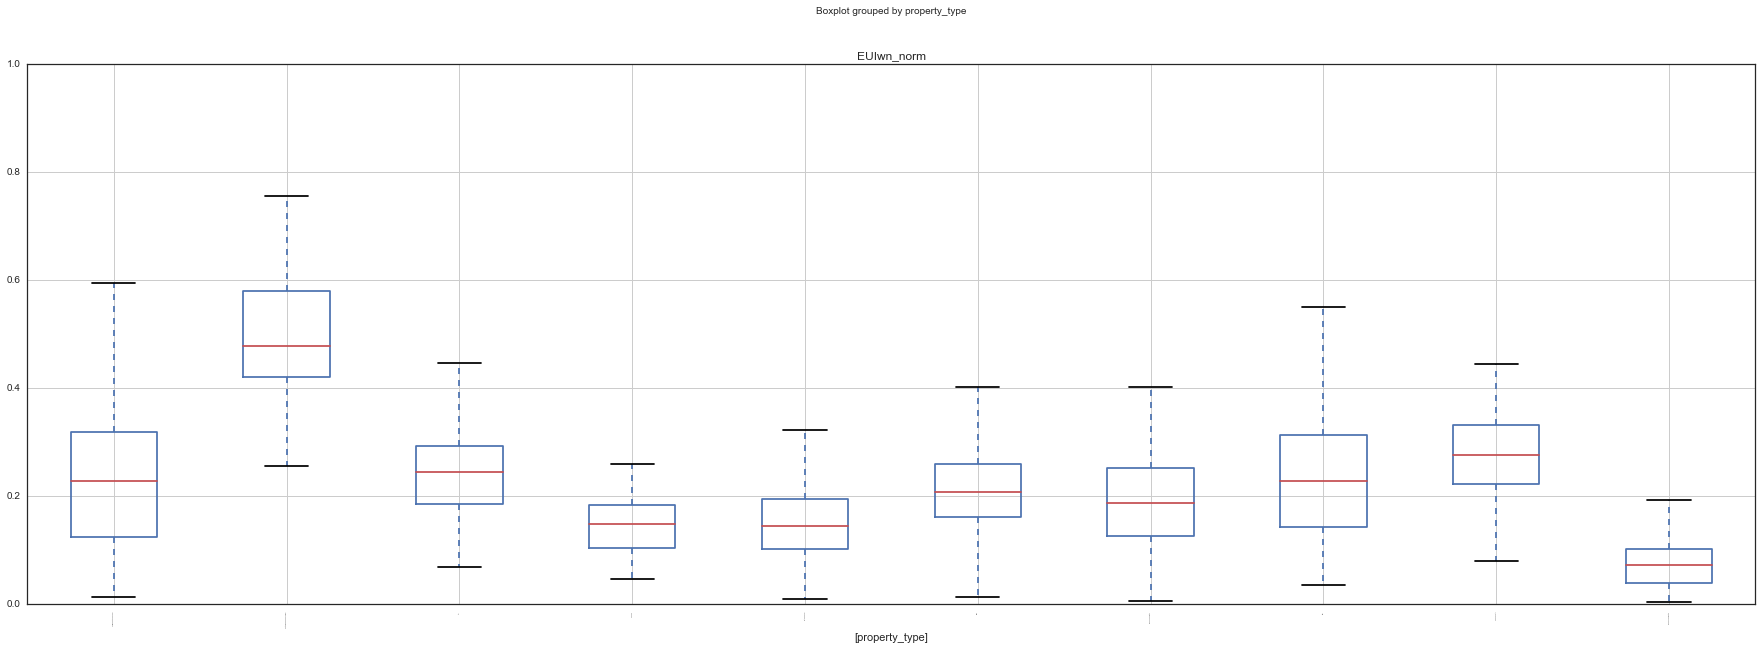

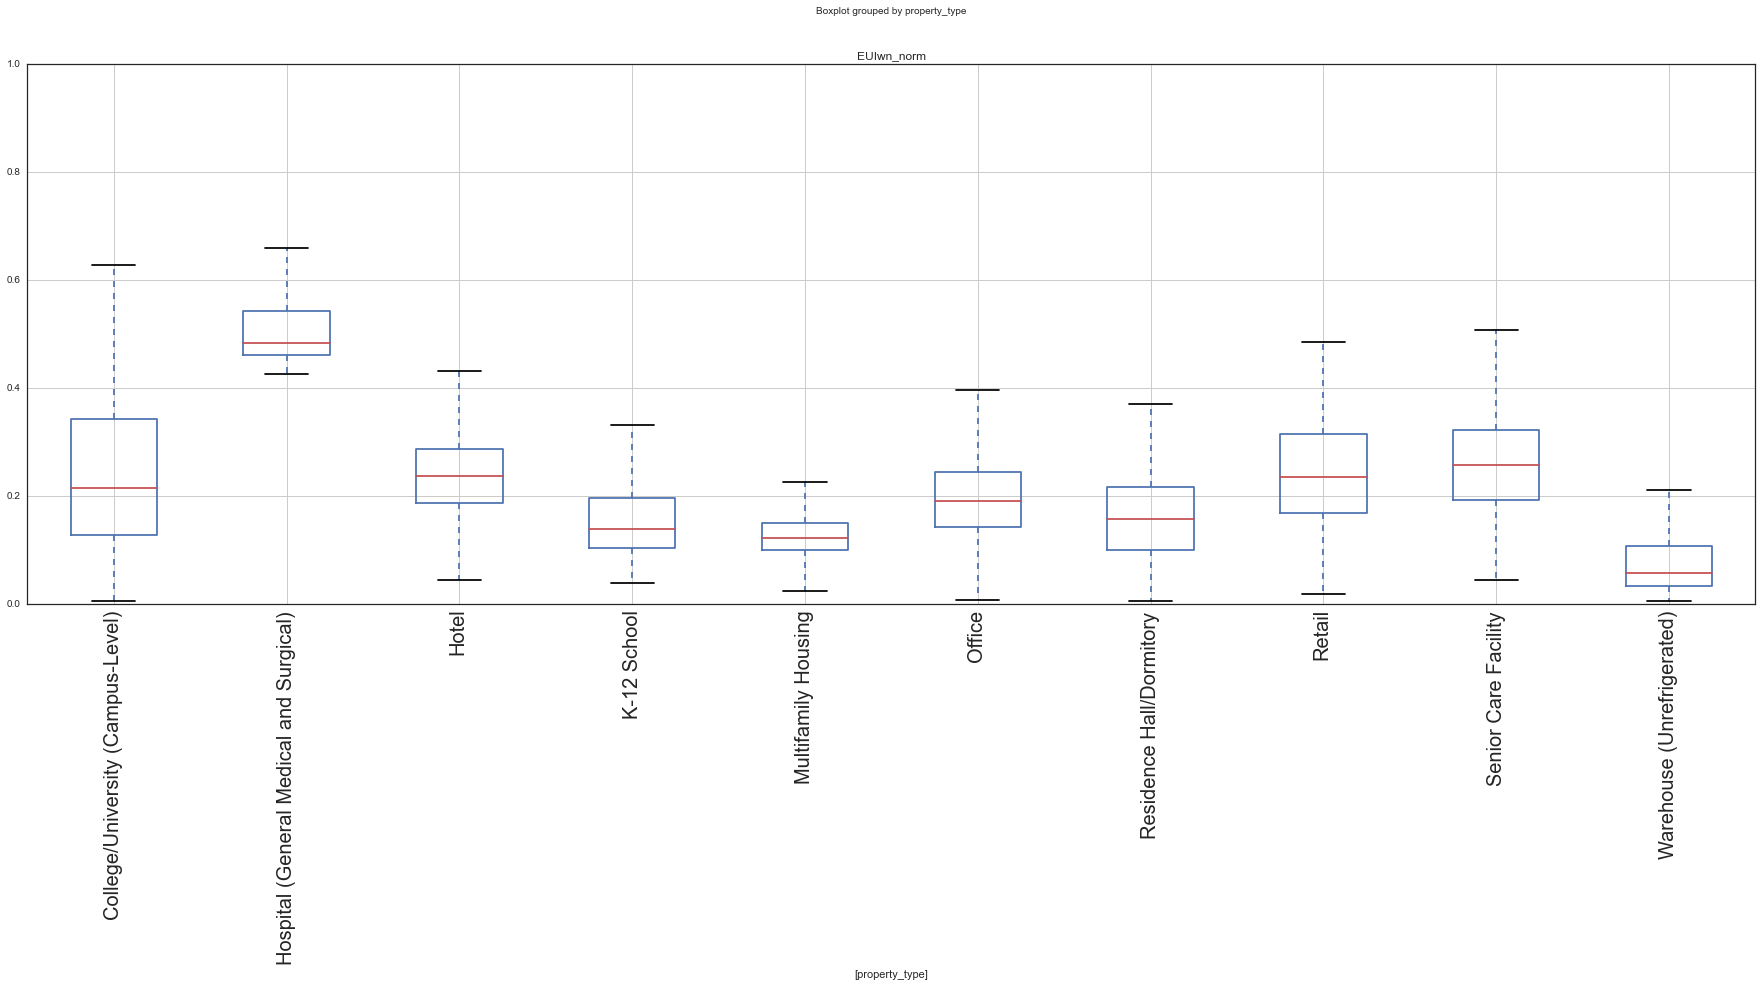

In [20]:
plt.figure(figsize=(10,10))

a1 = top10_2011[['property_type', 'EUIwn_norm']].boxplot(by='property_type', rot=90, figsize=(30,10), fontsize=0)
a2 = top10_2012[['property_type', 'EUIwn_norm']].boxplot(by='property_type', rot=90, figsize=(30,10), fontsize=20)

plt.show()

# 5. Overview of Relationships

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1102fce50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11295c7d0>]], dtype=object)

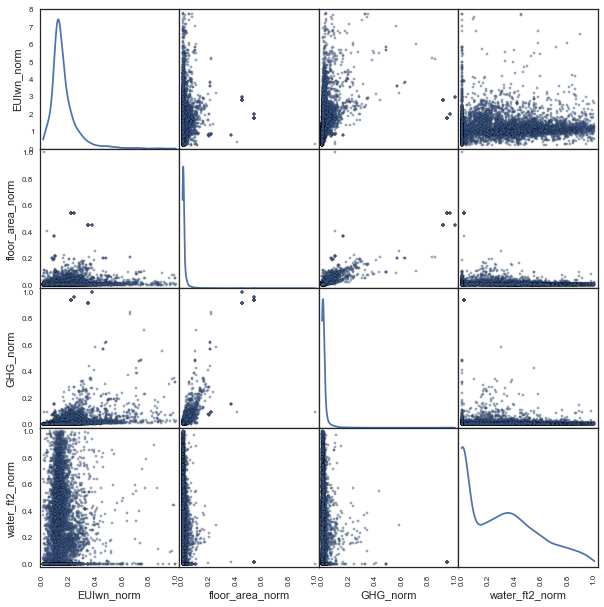

In [11]:
pd.scatter_matrix(buildings[['EUIwn_norm', 'floor_area_norm', 'GHG_norm', 'water_ft2_norm']], figsize=(10,10), diagonal='kde')

**Initial Observations**
1. The data still has rather long tails for each main variable, something that probably makes more sense to look at when analyzing specific **property_type** sub-groups.
2. **EUIwn** has a nice looking normal distribution, but with a rather long tail.
3. The most obvious relationship is the positive correlation between **GHG** and **floor_area**, which makes sense, given that they are both absolute values, and larger buildings should be producing more emissions.
4. A potential correlation between **EUIwn** and **GHG** also looks like it might be there.
5. Another potential relationship exists between **EUIwn** and **water_ft2**

*NOTE: The next graphs have points that vary by size with **floor_area** to see any additional trends by size.*

# 6. ENERGY STAR Rating

A buildings ENERGY STAR score is based on a score of 0 to 100, with 100 being the best score. This number is derived from the ENERGY STAR Program's "Portfolio Manager" tool. In general, it is a benchmark of efficiency against other buildings of the same type using the national CBECS database, and should probably correlate with **EUI** when looking at data by **property_type**.

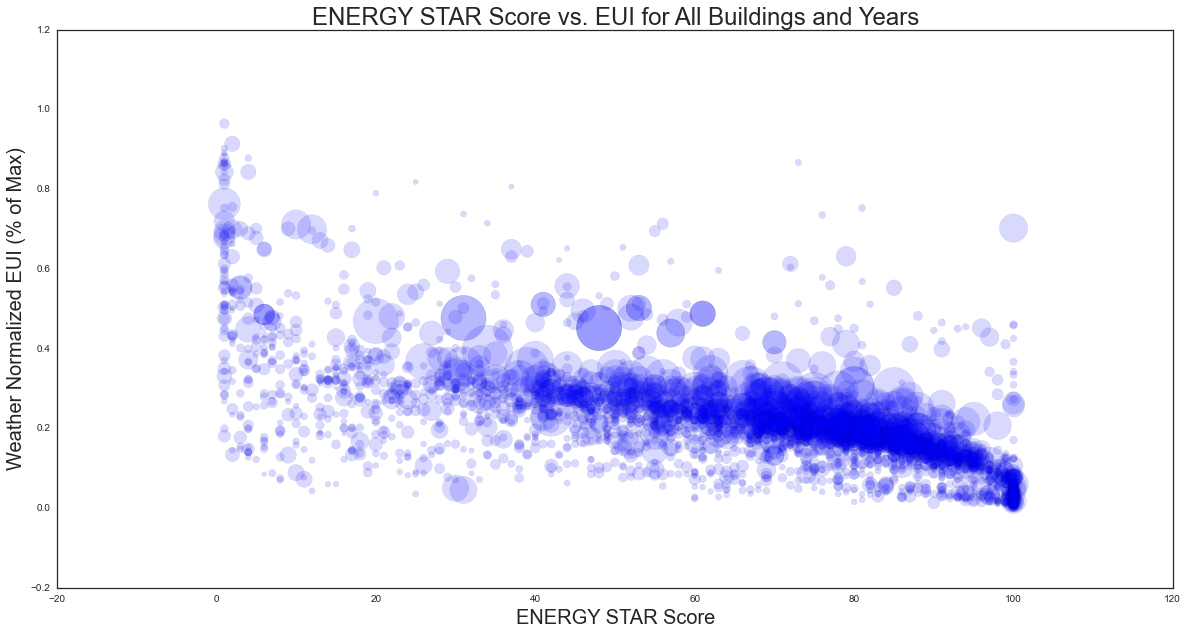

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(111)
plt.title('ENERGY STAR Score vs. EUI for All Buildings and Years', fontsize=24)
plt.xlabel('ENERGY STAR Score', fontsize=20)
plt.ylabel('Weather Normalized EUI (% of Max)', fontsize=20)
plt.scatter(buildings.energy_star, buildings.EUIwn_norm, 
            s=buildings.floor_area_localnorm*10000,
            alpha=0.15,
            c='b')

The figure above, for all observations, shows a general downward trend, as expected, but the wide variance in usage from the ENERGY STAR Score, suggests that, especially for the middle tier of buidlings, energy intensity can vary widely at various scores, and should probably be analyzed by **property_type**. The data also suggests a more 'S' shaped relationship, with both low and high scores having out-sized impacts on **EUI**.

The next graphs show how these change for the **Multifamily** and **Office** subgroups. The relationship for **Offices** is much clearer, but not so for **Multifamily**.

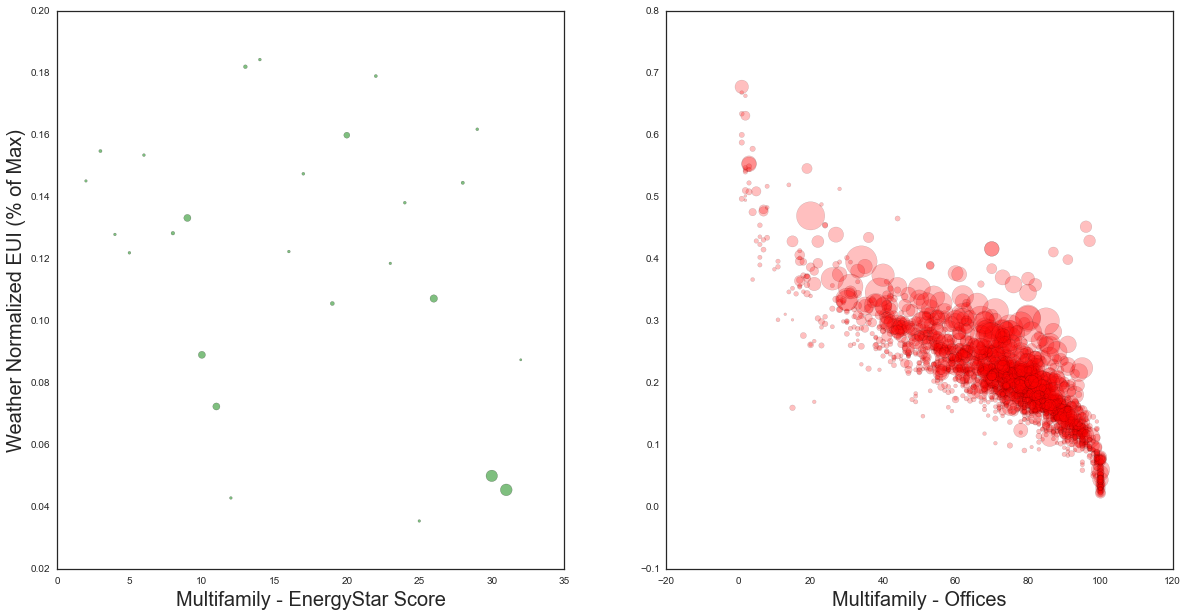

In [25]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.ylabel('Weather Normalized EUI (% of Max)', fontsize=20)
plt.xlabel('Multifamily - EnergyStar Score', fontsize=20)
plt.scatter(multifamily.energy_star, multifamily.EUIwn_norm, 
            s=multifamily.floor_area_localnorm*1000,
            alpha=0.5,
            c='g')

plt.subplot(122)
plt.xlabel('Multifamily - Offices', fontsize=20)
plt.scatter(office.energy_star, office.EUIwn_norm, 
            s=office.floor_area_localnorm*1000,
            alpha=0.25,
            c='r')

# 7. Water Usage

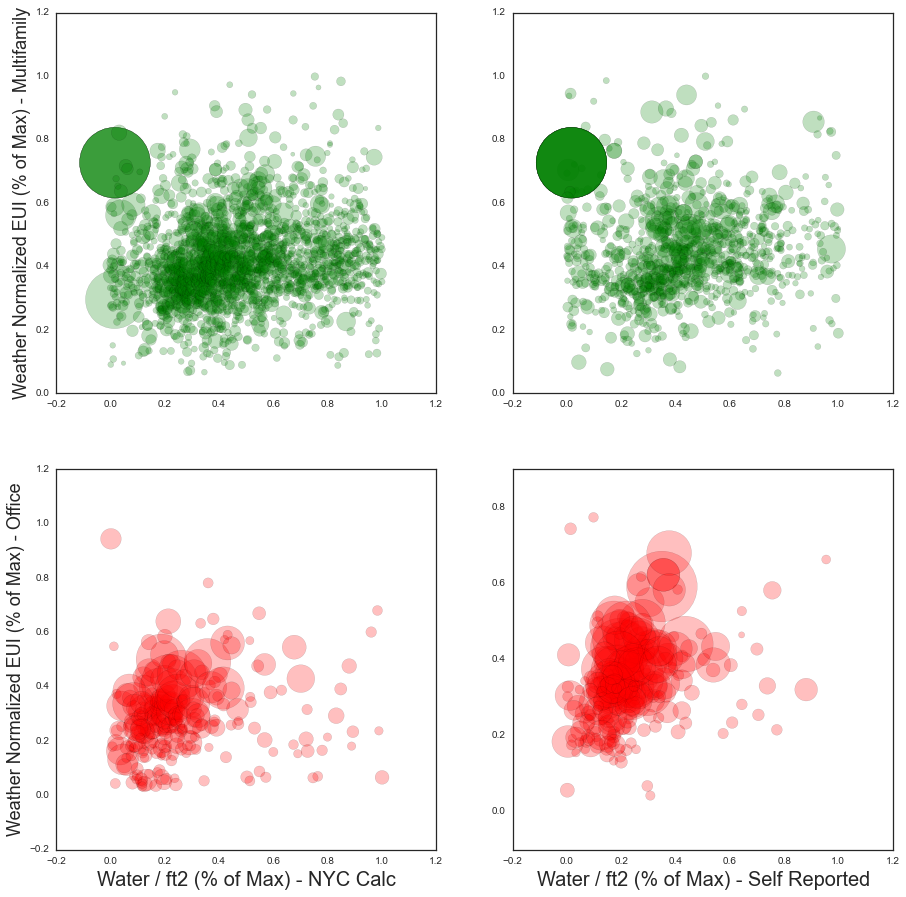

In [30]:
# create the mf data set
mf_water = multifamily_2012[(multifamily_2012.water_ft2 > 0)]
mf_w1 = mf_water[mf_water['water_method'] == 'ABS']
mf_w2 = mf_water[mf_water['water_method'] == 'Manual']

# create the of data set
of_water = office_2012[(office_2012.water_ft2 > 0)]
of_w1 = of_water[of_water['water_method'] == 'ABS']
of_w2 = of_water[of_water['water_method'] == 'Manual']


plt.figure(figsize=(15,15))

# Manual Water - MF
plt.subplot(221)
plt.ylabel('Weather Normalized EUI (% of Max) - Multifamily', fontsize=18)
plt.scatter(mf_w1.water_ft2_localnorm,
            mf_w1.EUIwn_localnorm, 
            s=mf_w1.floor_area_localnorm*5000, 
            alpha=0.25,
            c='g',)

# Auto Water - MF
plt.subplot(222)
plt.scatter(mf_w2.water_ft2_localnorm,
            mf_w2.EUIwn_localnorm, 
            s=mf_w2.floor_area_localnorm*5000, 
            alpha=0.25,
            c='g',)

# Manual Water - OF
plt.subplot(223)
plt.ylabel('Weather Normalized EUI (% of Max) - Office', fontsize=18)
plt.xlabel('Water / ft2 (% of Max) - NYC Calc', fontsize=20)
plt.scatter(of_w1.water_ft2_localnorm,
            of_w1.EUIwn_localnorm, 
            s=of_w1.floor_area_localnorm*5000, 
            alpha=0.25,
            c='r',)

# Auto Water - OF
plt.subplot(224)
plt.xlabel('Water / ft2 (% of Max) - Self Reported', fontsize=20)
plt.scatter(of_w2.water_ft2_localnorm,
            of_w2.EUIwn_localnorm, 
            s=of_w2.floor_area_localnorm*5000, 
            alpha=0.25,
            c='r',)



We might expect **EUI** to have some sort of general relationship to **water_ft2**, which is what the figures above show. The first row shows the **Multifamily** dataset, while the second row shows **Offices**. The columns split the data in to self reported, "Manual", or calculated by the city "ABS". 

The trends is much clearer for **Offices**, and more clear from the "Manual" method.

# 8. Next Steps

Next steps mainly revolve around bringing in other data sources to see how they will relate to **EUI**. In particular, I am interested in data that can be assigned to the **BBL** level of granularity, or even to specific buildings. Categories of data I am particularly interested in are socio-economic indicators or demographic information.

**Data sets to explore**

NYC data sets that could be relevant, especially for **Multifamily**, and that are by **BBL**.

|Name | Source |
|---| --- |
| Housing Maintenance Code Complaints | [Source](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Complaints/uwyv-629c)|
| Housing Maintenance Code Violations | [Source](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5) |
| DOB Complaints Received | [Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv) |
| Buildings with Boilers | [Source](https://data.cityofnewyork.us/Housing-Development/Oil-Boilers-Detailed-Fuel-Consumption-and-Building/jfzu-yy6n) |

[U.S. Census Data](http://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml) could also be interesting. Although the smallest geographical area covered is Public Use Microdata Area [map for NYC](http://www.nyc.gov/html/dcp/pdf/lucds/puma_maps.pdf), of which there are 56, which is less than half of the 178 zip codes in the buildings data.

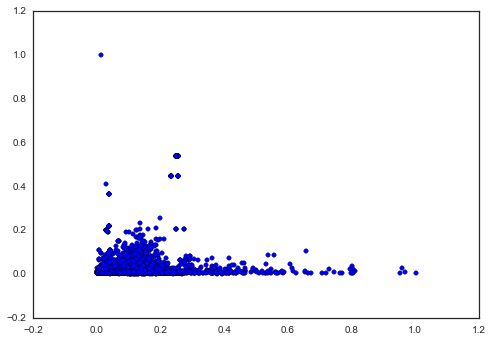

In [32]:
plt.figure()
plt.subplot(111)
plt.scatter(top10.EUI_norm, top10.floor_area_norm)
plt.show()

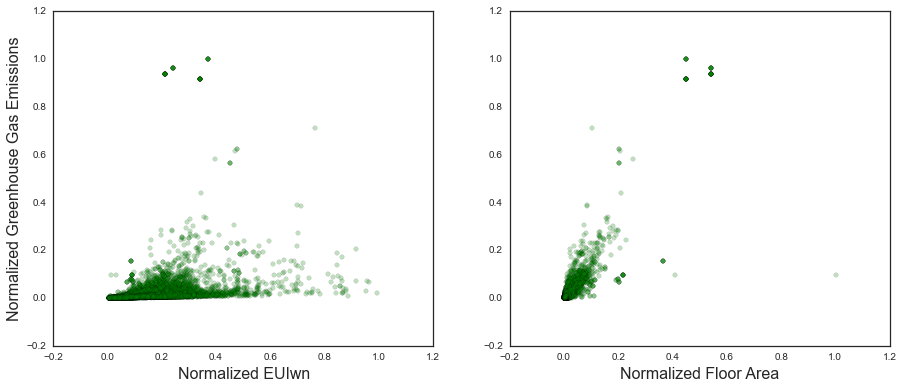

In [59]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(top10.EUIwn_norm, top10.GHG_norm, alpha=0.25, c='green')
plt.ylabel('Normalized Greenhouse Gas Emissions', fontsize=16)
plt.xlabel('Normalized EUIwn', fontsize=16)
plt.subplot(122)
plt.scatter(top10.floor_area_norm, top10.GHG_norm, alpha=0.25, c='green')
plt.xlabel('Normalized Floor Area', fontsize=16)
plt.show()

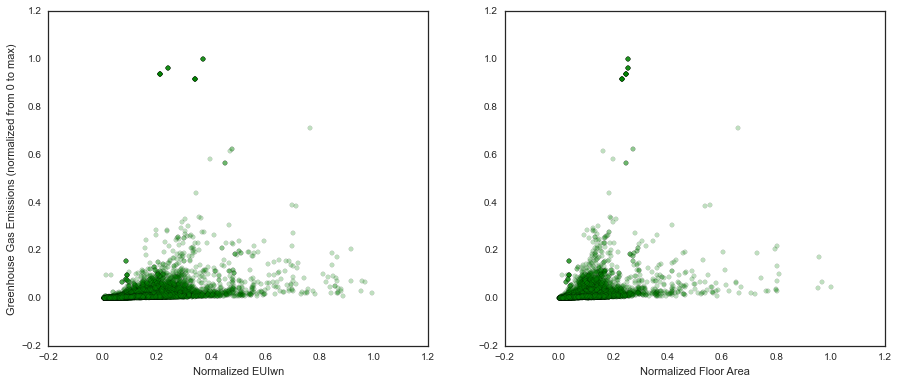

In [57]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(top10.EUIwn_norm, top10.GHG_norm, alpha=0.25, c='green')
plt.ylabel('Greenhouse Gas Emissions (normalized from 0 to max)')
plt.xlabel('Normalized EUIwn')
plt.subplot(122)
plt.scatter(top10.EUI_norm, top10.GHG_norm, alpha=0.25, c='green')
plt.xlabel('Normalized Floor Area')
plt.show()